In [46]:
import ee
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import show

from src.data import mtbs
from src.visualization import ee_viz
from src.visualization.gedi_viz import geo_plot
from src.visualization import gedi_viz
from src.data import gedi_loader
from src.data import fire_perimeters
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB


import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(mtbs)
importlib.reload(ee_viz)
importlib.reload(fire_perimeters)
importlib.reload(gedi_loader)
importlib.reload(gedi_viz)

<module 'src.visualization.gedi_viz' from '/home/jk871/fire-regen/src/visualization/gedi_viz.py'>

### Get McNally Fire Info

In [3]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")

firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2002']).filter_within_geometry(sierras)

fire = sierra_firep.get_fire('MCNALLY')

In [4]:
raster_file_path = "/maps/fire-regen/data/rasters/MCNALLY/"

In [5]:
raster_db = FireRastersDB(raster_file_path, 'mcnally')

## Visualize Location and Perimeter

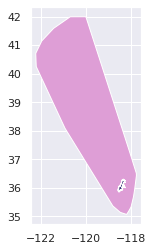

In [6]:
fire.overlay_fire_map(sierras)

In [7]:
fire.get().geometry.explore()

### Get fire GEDI shots and match them to NBR rasters

In [8]:
fire.load_gedi(load_buffer=True)

2023-05-07 00:26:05,312 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-07 00:26:09,994 INFO: Number of GEDI shots found: 55691 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]
2023-05-07 00:26:10,046 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-07 00:26:21,069 INFO: Number of GEDI shots found: 173361 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


### Get McNally severity rasters

In [10]:
gedi_dnbr6 = match_gedi_to_raster(fire.gedi, raster_db.get('dnbr6'), 3, ['severity'])
gedi_dnbr = match_gedi_to_raster(fire.gedi, raster_db.get('dnbr'), 3, ['severity'])
gedi_rdnbr = match_gedi_to_raster(fire.gedi, raster_db.get('rdnbr'), 3, ['severity'])

In [11]:
gedi_buffer_dnbr6 = match_gedi_to_raster(fire.gedi_buffer, raster_db.get('dnbr6'), 3, ['severity'])
gedi_buffer_dnbr = match_gedi_to_raster(fire.gedi_buffer, raster_db.get('dnbr'), 3, ['severity'])
gedi_buffer_rdnbr = match_gedi_to_raster(fire.gedi_buffer, raster_db.get('rdnbr'), 3, ['severity'])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

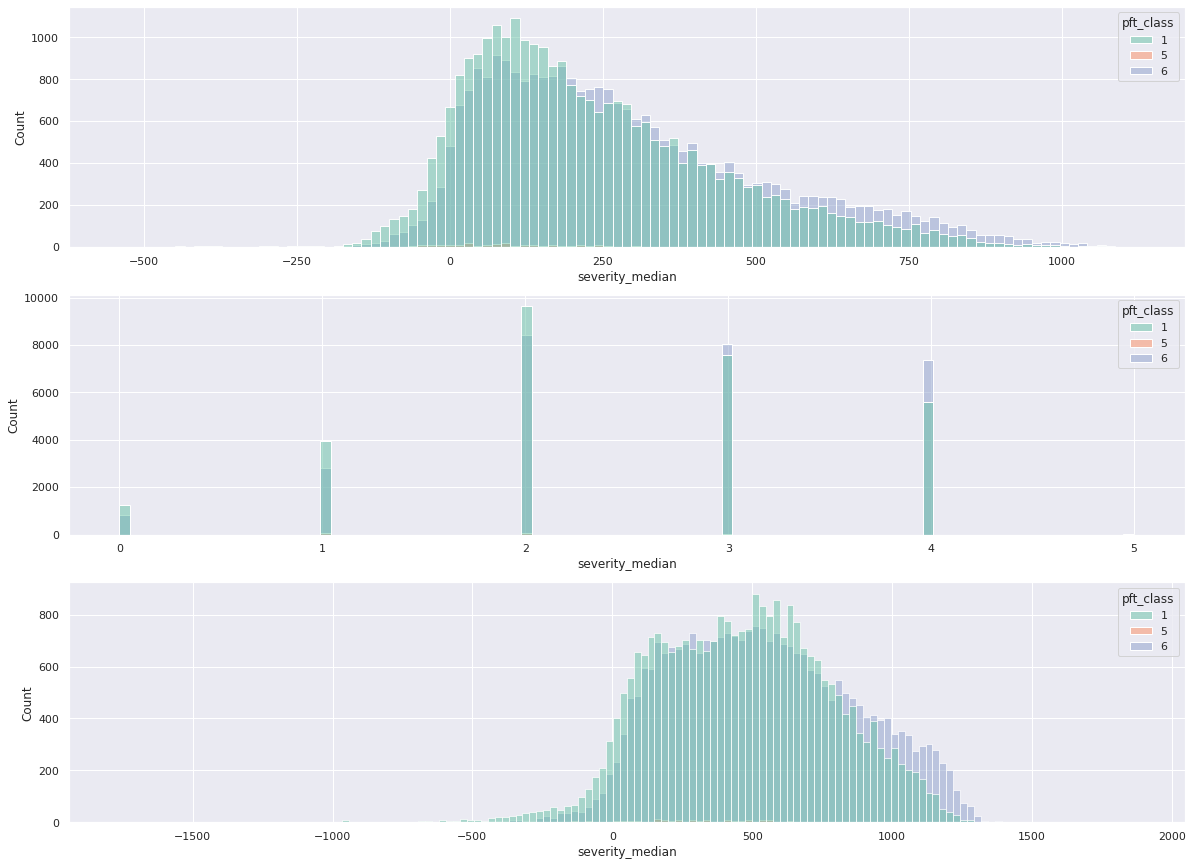

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(20,15))
sns.histplot(gedi_dnbr, x='severity_median', ax=ax[0], hue='pft_class',  palette='Set2')
sns.histplot(gedi_dnbr6, x='severity_median', ax=ax[1], hue='pft_class',  palette='Set2')
sns.histplot(gedi_rdnbr, x='severity_median', ax=ax[2], hue='pft_class',  palette='Set2')

(0.0, 1000.0)

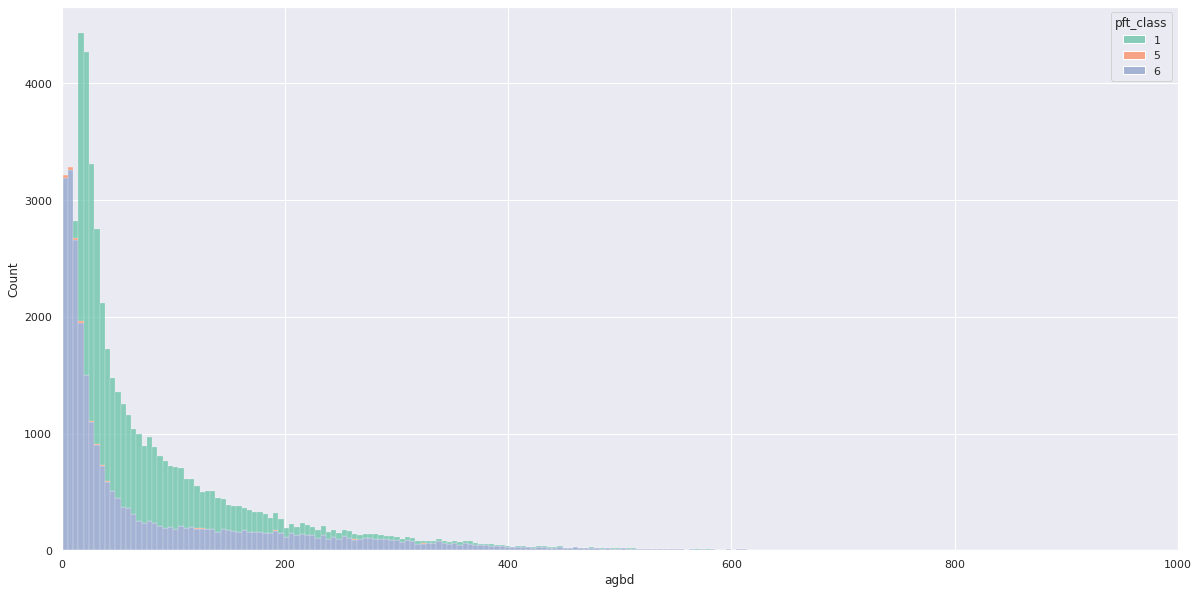

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.histplot(gedi_dnbr, x='agbd', ax=ax, hue='pft_class', multiple='stack', palette='Set2')
ax.set_xlim((0, 1000))

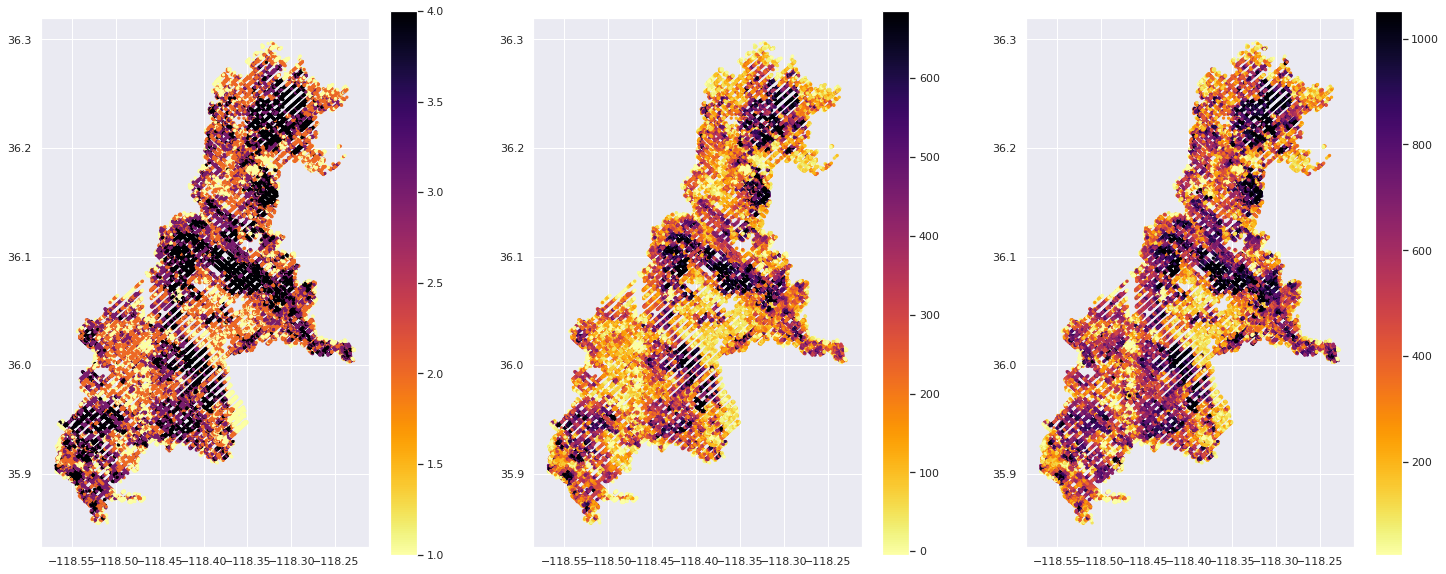

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(25,10))

geo_plot(gedi_dnbr6, ax[0], 'severity_median', vmin=1, vmax=4)
geo_plot(gedi_dnbr, ax[1], 'severity_mean')
geo_plot(gedi_rdnbr, ax[2], 'severity_mean')

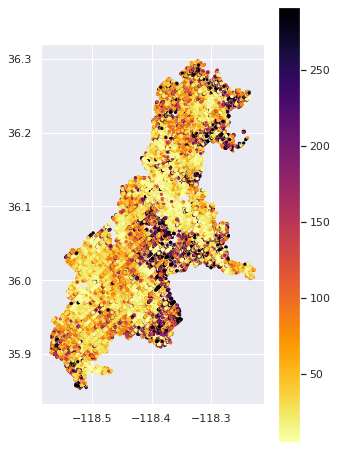

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5,8))

geo_plot(fire.gedi, ax, 'agbd')

In [18]:
# Divide unburned after into two segments
gedi_after = fire.gedi
gedi_after.absolute_time = pd.to_datetime(gedi_after.absolute_time, utc=True)
gedi_after_1 = gedi_after[gedi_after.absolute_time < '08-2020']
gedi_after_2 = gedi_after[gedi_after.absolute_time > '08-2020']

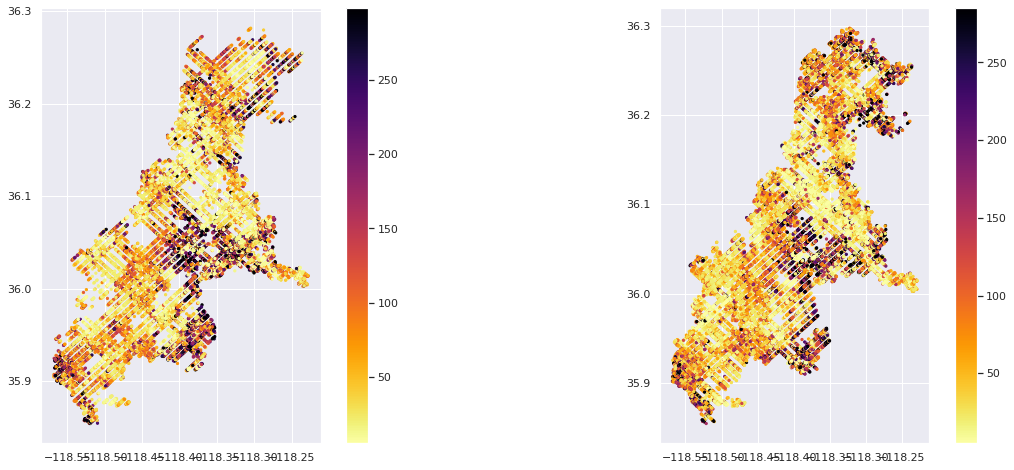

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

geo_plot(gedi_after_1, ax[0], 'agbd')
geo_plot(gedi_after_2, ax[1], 'agbd')

In [21]:
gedi_dnbr.corr()

/tmp/ipykernel_387478/608907356.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_dnbr.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000       -0.006664        0.040448 -0.022785   
lon_lowestmode     -0.006664        1.000000        0.650196  0.083897   
lat_lowestmode      0.040448        0.650196        1.000000 -0.002359   
agbd               -0.022785        0.083897       -0.002359  1.000000   
agbd_pi_lower      -0.010247        0.044204       -0.006880  0.378382   
agbd_pi_upper      -0.012051        0.019495       -0.000690  0.964520   
agbd_se             0.042361       -0.248268        0.010332 -0.030264   
sensitivity        -0.127476       -0.050439        0.019970  0.103308   
pft_class          -0.042825        0.251988       -0.008933  0.051939   
severity_sample    -0.004370        0.036516        0.039493 -0.242282   
severity_mean      -0.005320        0.040891        0.042975 -0.247340   
severity_std       -0.012419        0.016415       -0.013390 -0.071797   
severity_median    -0.005034        0.040826        0.044520 -0.247024   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.010247      -0.012051  0.042361    -0.127476   
lon_lowestmode        0.044204       0.019495 -0.248268    -0.050439   
lat_lowestmode       -0.006880      -0.000690  0.010332     0.019970   
agbd                  0.378382       0.964520 -0.030264     0.103308   
agbd_pi_lower         1.000000       0.394717 -0.114758     0.077780   
agbd_pi_upper         0.394717       1.000000  0.213920     0.197944   
agbd_se              -0.114758       0.213920  1.000000     0.359044   
sensitivity           0.077780       0.197944  0.359044     1.000000   
pft_class             0.118614      -0.193863 -0.999435    -0.357184   
severity_sample      -0.052496      -0.265781 -0.112906    -0.029109   
severity_mean        -0.047661      -0.273370 -0.125608    -0.034520   
severity_std         -0.007536      -0.083264 -0.058003    -0.007392   
severity_median      -0.048151      -0.272122 -0.121376    -0.033093   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.042825        -0.004370      -0.005320     -0.012419   
lon_lowestmode    0.251988         0.036516       0.040891      0.016415   
lat_lowestmode   -0.008933         0.039493       0.042975     -0.013390   
agbd              0.051939        -0.242282      -0.247340     -0.071797   
agbd_pi_lower     0.118614        -0.052496      -0.047661     -0.007536   
agbd_pi_upper    -0.193863        -0.265781      -0.273370     -0.083264   
agbd_se          -0.999435        -0.112906      -0.125608     -0.058003   
sensitivity      -0.357184        -0.029109      -0.034520     -0.007392   
pft_class         1.000000         0.108456       0.121059      0.056968   
severity_sample   0.108456         1.000000       0.955630      0.359323   
severity_mean     0.121059         0.955630       1.000000      0.383162   
severity_std      0.056968         0.359323       0.383162      1.000000   
severity_median   0.116841         0.957929       0.992383      0.365863   

                 severity_median  
shot_number            -0.005034  
lon_lowestmode          0.040826  
lat_lowestmode          0.044520  
agbd                   -0.247024  
agbd_pi_lower          -0.048151  
agbd_pi_upper          -0.272122  
agbd_se                -0.121376  
sensitivity            -0.033093  
pft_class               0.116841  
severity_sample         0.957929  
severity_mean           0.992383  
severity_std            0.365863  
severity_median         1.000000

### Look at GEDI outliers - i.e. high values

In [31]:
gedi_dnbr[gedi_dnbr.agbd > 1000]

shot_number                     absolute_time  lon_lowestmode  \
10648    64721100200116091  2020-02-02 21:14:54.552208+00:00     -118.560105   
17815   118601100300289871  2021-01-15 11:06:18.993773+00:00     -118.481948   
35510    24930500300230510  2019-05-22 11:10:19.835996+01:00     -118.341713   
35512    24930500300230512  2019-05-22 11:10:19.852528+01:00     -118.340772   
38416   127400500200081239  2021-03-13 05:18:10.738722+00:00     -118.275374   
39571   127400600200434996  2021-03-13 05:18:10.387484+00:00     -118.288101   
55183    53781100300289830  2019-11-24 08:30:24.124851+00:00     -118.419679   
77579    64720800200119988  2020-02-02 21:14:55.324947+00:00     -118.523486   
82338   127400800200086465  2021-03-13 05:18:10.672610+00:00     -118.286716   
82340   127400800200086468  2021-03-13 05:18:10.697402+00:00     -118.285305   
82341   127400800200086469  2021-03-13 05:18:10.705666+00:00     -118.284834   
82343   127400800200086472  2021-03-13 05:18:10.730458+00:00     -118.283424   
94782    56941100200082910  2019-12-14 17:05:22.108726+00:00     -118.375421   
96338   127400800200086458  2021-03-13 05:18:10.614762+00:00     -118.289990   
97176   127400600200434923  2021-03-13 05:18:09.767646+00:00     -118.323403   
97179   127400600200434926  2021-03-13 05:18:09.792438+00:00     -118.321991   
97180   127400600200434927  2021-03-13 05:18:09.800702+00:00     -118.321520   
97313    56940800200088288  2019-12-14 17:05:22.104594+00:00     -118.382484   
109192  127400800200086464  2021-03-13 05:18:10.664346+00:00     -118.287186   
109193  127400800200086467  2021-03-13 05:18:10.689138+00:00     -118.285779   
109388  127400600200434994  2021-03-13 05:18:10.370952+00:00     -118.289041   
112877  128620600200476547  2021-03-21 02:12:54.679773+00:00     -118.348304   
116590  127400500200081240  2021-03-13 05:18:10.746986+00:00     -118.274904   
117862  127400600200434933  2021-03-13 05:18:09.850286+00:00     -118.318692   
117864  127400600200434949  2021-03-13 05:18:09.982510+00:00     -118.311164   
118199  127400600200434956  2021-03-13 05:18:10.056886+00:00     -118.306927   
118200  127400600200434957  2021-03-13 05:18:10.065150+00:00     -118.306449   
127575  127400500200081141  2021-03-13 05:18:09.928794+00:00     -118.321497   
127576  127400500200081142  2021-03-13 05:18:09.937058+00:00     -118.321027   
127577  127400500200081143  2021-03-13 05:18:09.945322+00:00     -118.320552   
131577   56940800200088289  2019-12-14 17:05:22.112858+00:00     -118.382016   
134730  128620800200476609  2021-03-21 02:12:55.154967+00:00     -118.336072   
134738  128620800200476618  2021-03-21 02:12:55.229343+00:00     -118.331768   
135736  128621100200040767  2021-03-21 02:12:55.291323+00:00     -118.320808   

        lat_lowestmode         agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
10648        35.903112  1055.548462     727.947083    1443.841553  11.205721   
17815        35.981446  1043.020874     830.603394    1279.598389   4.370355   
35510        36.204349  1542.545044    1138.386353    2007.982178  11.314012   
35512        36.203662  1588.741699    1177.864380    2060.979980  11.329254   
38416        36.065574  1571.762451    1285.266113    1887.060791   5.209987   
39571        36.048670  1154.231079     925.966736    1407.619019   4.544658   
55183        36.097971  1001.945496     795.432861    1232.264526   4.306366   
77579        35.937500  1089.933350     870.807739    1333.624390   4.443701   
82338        36.041332  1303.819336    1054.500977    1579.569458   4.781245   
82340        36.042364  1016.347107     807.760681    1248.863770   4.328775   
82341        36.042709  1415.392456    1150.522827    1707.676758   4.959074   
82343        36.043741  1365.572510    1107.632935    1650.487061   4.879535   
94782        35.994854  1570.566162    1284.234619    1885.688965   5.208060   
96338        36.038932  1696.421509    1392.795898    2029.961670   5.411252   
97176        3

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

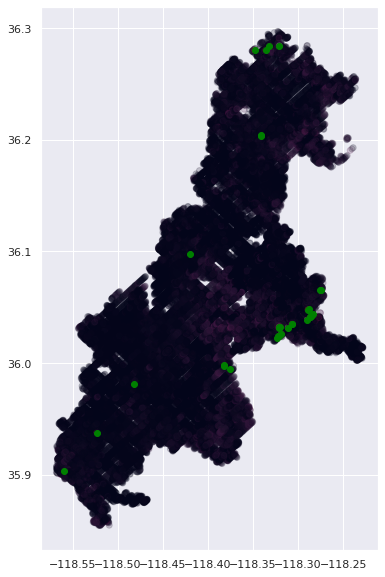

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

gedi_dnbr.plot(column='agbd', ax=ax, alpha=0.2)
gedi_dnbr[gedi_dnbr.agbd > 1000].plot(column='agbd', ax=ax, color='green')

(0.0, 700.0)

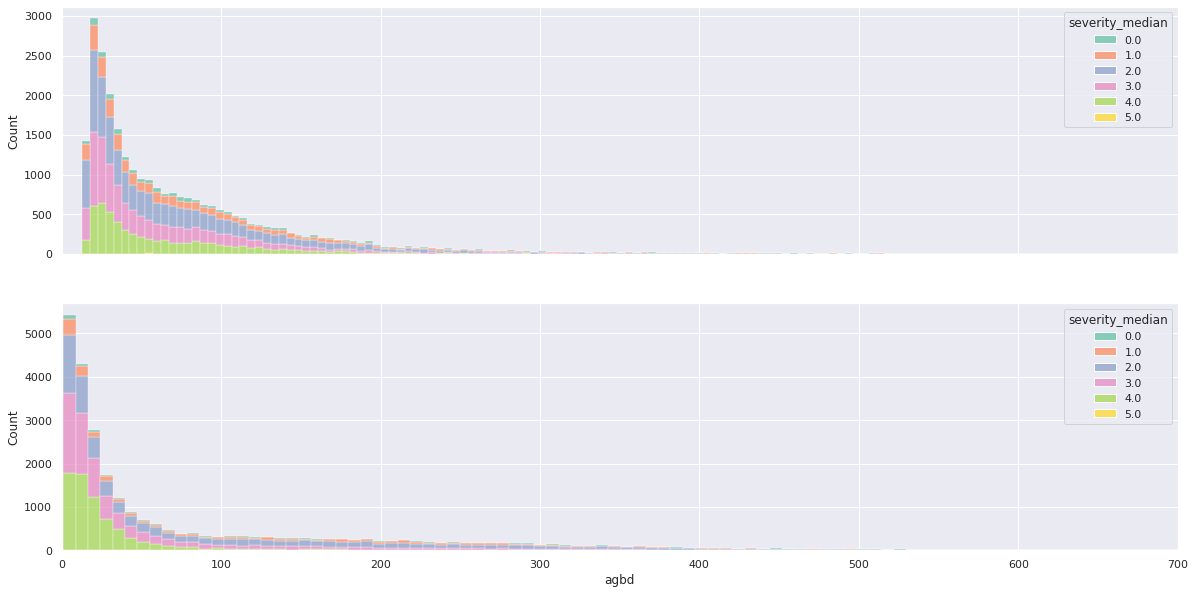

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(gedi_dnbr6[gedi_dnbr6.pft_class==1], x='agbd', ax=ax[0], hue='severity_median', multiple='stack', palette='Set2')
g = sns.histplot(gedi_dnbr6[gedi_dnbr6.pft_class==6], x='agbd', ax=ax[1], hue='severity_median', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

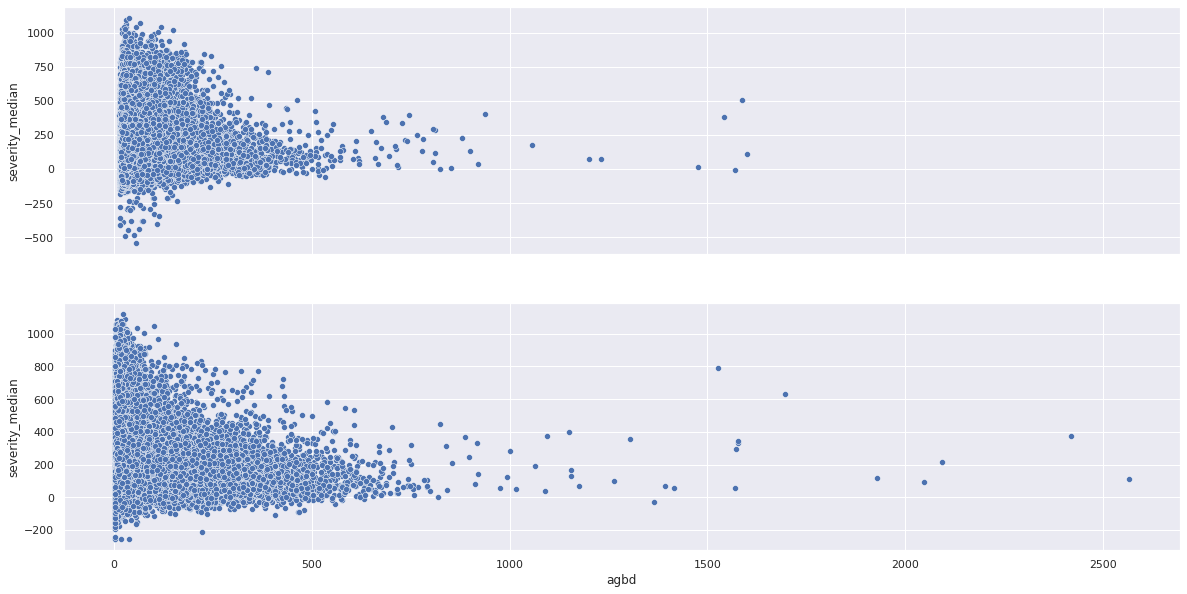

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(gedi_dnbr[gedi_dnbr.pft_class==1], x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(gedi_dnbr[gedi_dnbr.pft_class==6], x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

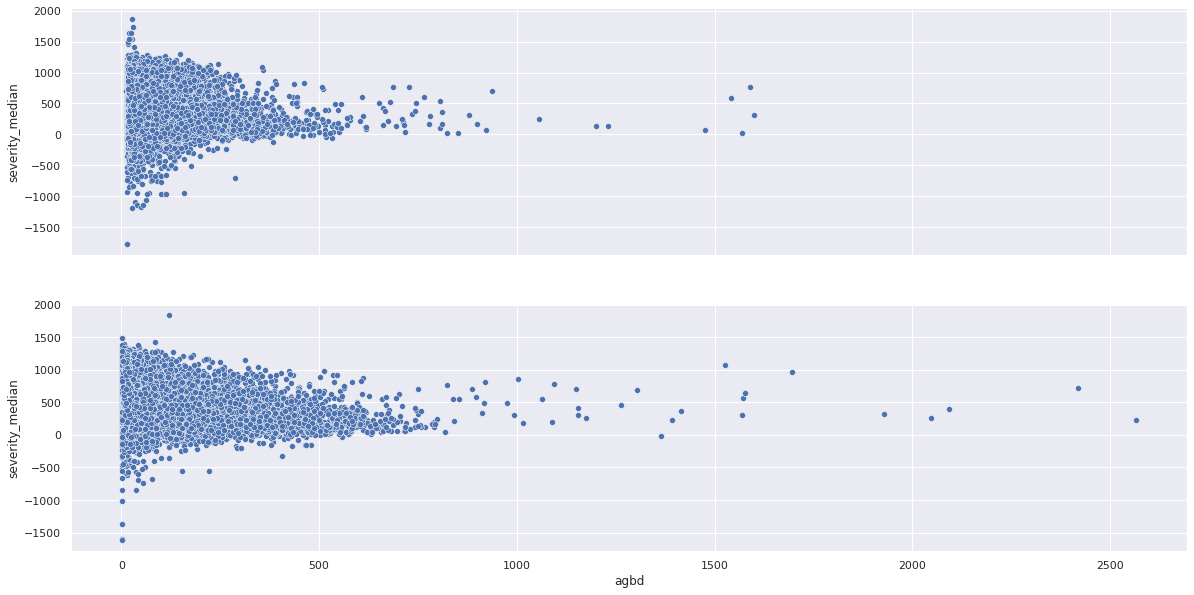

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(gedi_rdnbr[gedi_rdnbr.pft_class==1], x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(gedi_rdnbr[gedi_rdnbr.pft_class==6], x='agbd', y='severity_median', ax=ax[1])

### Look at unburned buffer zone GEDI

In [39]:
print('AGBD in the fire')
print(gedi_dnbr.agbd.describe())

print('AGBD out of the fire')
print(gedi_buffer_dnbr.agbd.describe())

AGBD in the fire
count    55691.000000
mean        83.700313
std        104.693726
min          0.882875
25%         19.932028
50%         43.051460
75%        110.103786
max       2566.329346
Name: agbd, dtype: float64
AGBD out of the fire
count    173361.000000
mean        105.831987
std         110.968295
min           0.742466
25%          30.964632
50%          71.829590
75%         144.788544
max        2760.429688
Name: agbd, dtype: float64


In [41]:
gedi_all = pd.concat([fire.gedi, fire.gedi_buffer])

In [44]:
gedi_all_dnbr = pd.concat([gedi_dnbr, gedi_buffer_dnbr])

<AxesSubplot: >

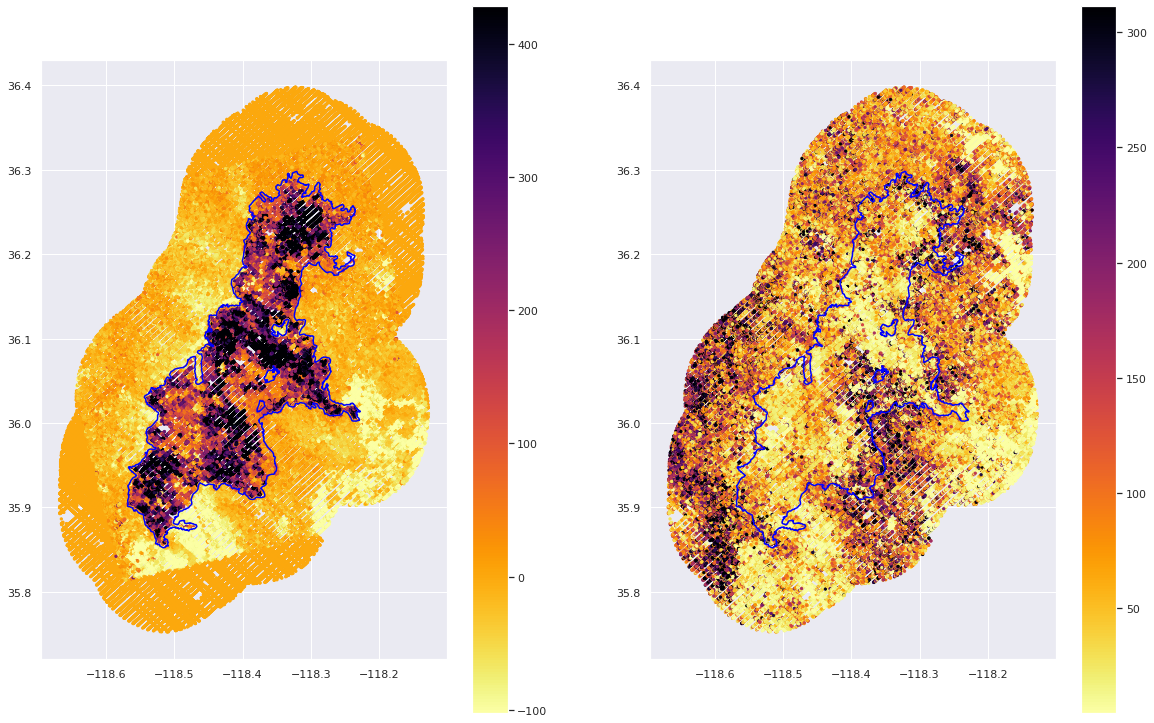

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))

geo_plot(gedi_all_dnbr, ax[0], 'severity_mean')
geo_plot(gedi_all_dnbr, ax[1], 'agbd')
fire.fire.boundary.plot(ax=ax[0], color='blue')
fire.fire.boundary.plot(ax=ax[1], color='blue')

<AxesSubplot: >

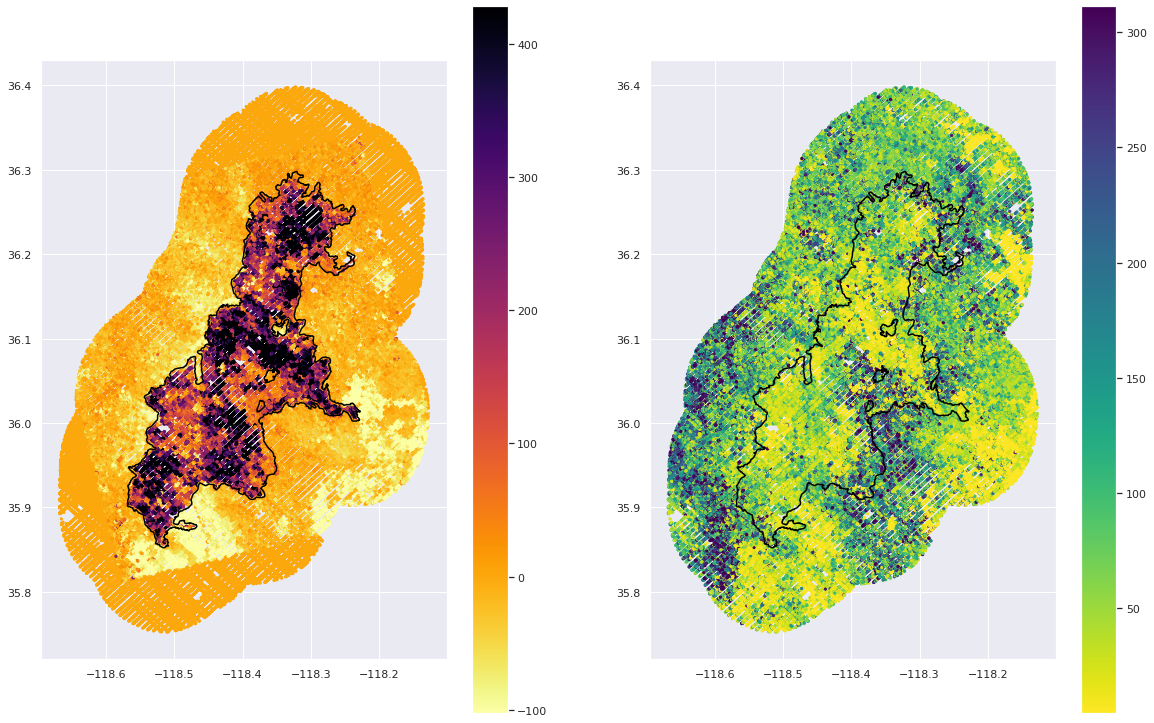

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))

geo_plot(gedi_all_dnbr, ax[0], 'severity_mean')
gedi_viz.geo_plot(gedi_all_dnbr, ax[1], 'agbd', cmap='viridis_r')
fire.fire.boundary.plot(ax=ax[0], color='black')
fire.fire.boundary.plot(ax=ax[1], color='black')

<AxesSubplot: >

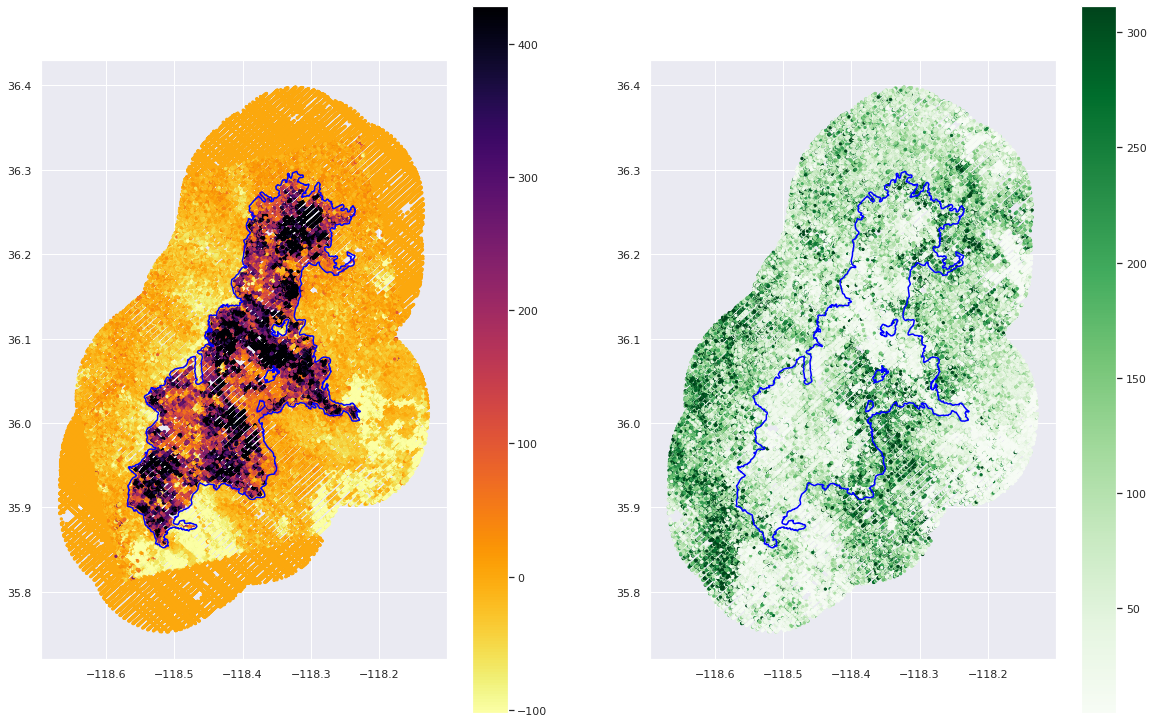

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))

geo_plot(gedi_all_dnbr, ax[0], 'severity_mean')
gedi_viz.geo_plot(gedi_all_dnbr, ax[1], 'agbd', cmap='Greens')
fire.fire.boundary.plot(ax=ax[0], color='blue')
fire.fire.boundary.plot(ax=ax[1], color='blue')

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

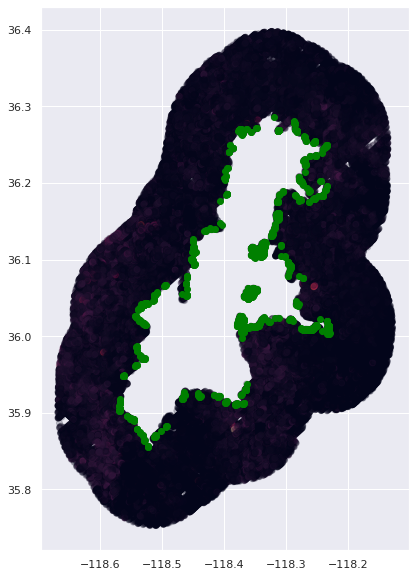

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

gedi_buffer_dnbr.plot(column='agbd', ax=ax, alpha=0.2)
gedi_buffer_dnbr6[gedi_buffer_dnbr6.severity_median != 0].plot(column='agbd', ax=ax, color='green')

In [53]:
gedi_dnbr.corr()

/tmp/ipykernel_387478/608907356.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_dnbr.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000       -0.006664        0.040448 -0.022785   
lon_lowestmode     -0.006664        1.000000        0.650196  0.083897   
lat_lowestmode      0.040448        0.650196        1.000000 -0.002359   
agbd               -0.022785        0.083897       -0.002359  1.000000   
agbd_pi_lower      -0.010247        0.044204       -0.006880  0.378382   
agbd_pi_upper      -0.012051        0.019495       -0.000690  0.964520   
agbd_se             0.042361       -0.248268        0.010332 -0.030264   
sensitivity        -0.127476       -0.050439        0.019970  0.103308   
pft_class          -0.042825        0.251988       -0.008933  0.051939   
severity_sample    -0.004370        0.036516        0.039493 -0.242282   
severity_mean      -0.005320        0.040891        0.042975 -0.247340   
severity_std       -0.012419        0.016415       -0.013390 -0.071797   
severity_median    -0.005034        0.040826        0.044520 -0.247024   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.010247      -0.012051  0.042361    -0.127476   
lon_lowestmode        0.044204       0.019495 -0.248268    -0.050439   
lat_lowestmode       -0.006880      -0.000690  0.010332     0.019970   
agbd                  0.378382       0.964520 -0.030264     0.103308   
agbd_pi_lower         1.000000       0.394717 -0.114758     0.077780   
agbd_pi_upper         0.394717       1.000000  0.213920     0.197944   
agbd_se              -0.114758       0.213920  1.000000     0.359044   
sensitivity           0.077780       0.197944  0.359044     1.000000   
pft_class             0.118614      -0.193863 -0.999435    -0.357184   
severity_sample      -0.052496      -0.265781 -0.112906    -0.029109   
severity_mean        -0.047661      -0.273370 -0.125608    -0.034520   
severity_std         -0.007536      -0.083264 -0.058003    -0.007392   
severity_median      -0.048151      -0.272122 -0.121376    -0.033093   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.042825        -0.004370      -0.005320     -0.012419   
lon_lowestmode    0.251988         0.036516       0.040891      0.016415   
lat_lowestmode   -0.008933         0.039493       0.042975     -0.013390   
agbd              0.051939        -0.242282      -0.247340     -0.071797   
agbd_pi_lower     0.118614        -0.052496      -0.047661     -0.007536   
agbd_pi_upper    -0.193863        -0.265781      -0.273370     -0.083264   
agbd_se          -0.999435        -0.112906      -0.125608     -0.058003   
sensitivity      -0.357184        -0.029109      -0.034520     -0.007392   
pft_class         1.000000         0.108456       0.121059      0.056968   
severity_sample   0.108456         1.000000       0.955630      0.359323   
severity_mean     0.121059         0.955630       1.000000      0.383162   
severity_std      0.056968         0.359323       0.383162      1.000000   
severity_median   0.116841         0.957929       0.992383      0.365863   

                 severity_median  
shot_number            -0.005034  
lon_lowestmode          0.040826  
lat_lowestmode          0.044520  
agbd                   -0.247024  
agbd_pi_lower          -0.048151  
agbd_pi_upper          -0.272122  
agbd_se                -0.121376  
sensitivity            -0.033093  
pft_class               0.116841  
severity_sample         0.957929  
severity_mean           0.992383  
severity_std            0.365863  
severity_median         1.000000

In [54]:
gedi_rdnbr.corr()

/tmp/ipykernel_387478/588496934.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_rdnbr.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000       -0.006664        0.040448 -0.022785   
lon_lowestmode     -0.006664        1.000000        0.650196  0.083897   
lat_lowestmode      0.040448        0.650196        1.000000 -0.002359   
agbd               -0.022785        0.083897       -0.002359  1.000000   
agbd_pi_lower      -0.010247        0.044204       -0.006880  0.378382   
agbd_pi_upper      -0.012051        0.019495       -0.000690  0.964520   
agbd_se             0.042361       -0.248268        0.010332 -0.030264   
sensitivity        -0.127476       -0.050439        0.019970  0.103308   
pft_class          -0.042825        0.251988       -0.008933  0.051939   
severity_sample    -0.011437        0.049851        0.046318 -0.278585   
severity_mean      -0.011525        0.058366        0.053282 -0.300690   
severity_std       -0.017556       -0.015039       -0.025046 -0.031601   
severity_median    -0.011289        0.057394        0.056959 -0.308266   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.010247      -0.012051  0.042361    -0.127476   
lon_lowestmode        0.044204       0.019495 -0.248268    -0.050439   
lat_lowestmode       -0.006880      -0.000690  0.010332     0.019970   
agbd                  0.378382       0.964520 -0.030264     0.103308   
agbd_pi_lower         1.000000       0.394717 -0.114758     0.077780   
agbd_pi_upper         0.394717       1.000000  0.213920     0.197944   
agbd_se              -0.114758       0.213920  1.000000     0.359044   
sensitivity           0.077780       0.197944  0.359044     1.000000   
pft_class             0.118614      -0.193863 -0.999435    -0.357184   
severity_sample      -0.124739      -0.302431 -0.096777    -0.047708   
severity_mean        -0.130847      -0.329340 -0.116249    -0.057025   
severity_std         -0.092456      -0.036060  0.013308    -0.023191   
severity_median      -0.128527      -0.335923 -0.114617    -0.055046   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.042825        -0.011437      -0.011525     -0.017556   
lon_lowestmode    0.251988         0.049851       0.058366     -0.015039   
lat_lowestmode   -0.008933         0.046318       0.053282     -0.025046   
agbd              0.051939        -0.278585      -0.300690     -0.031601   
agbd_pi_lower     0.118614        -0.124739      -0.130847     -0.092456   
agbd_pi_upper    -0.193863        -0.302431      -0.329340     -0.036060   
agbd_se          -0.999435        -0.096777      -0.116249      0.013308   
sensitivity      -0.357184        -0.047708      -0.057025     -0.023191   
pft_class         1.000000         0.091790       0.110887     -0.013471   
severity_sample   0.091790         1.000000       0.904201     -0.021948   
severity_mean     0.110887         0.904201       1.000000     -0.023482   
severity_std     -0.013471        -0.021948      -0.023482      1.000000   
severity_median   0.109069         0.896929       0.981694     -0.091972   

                 severity_median  
shot_number            -0.011289  
lon_lowestmode          0.057394  
lat_lowestmode          0.056959  
agbd                   -0.308266  
agbd_pi_lower          -0.128527  
agbd_pi_upper          -0.335923  
agbd_se                -0.114617  
sensitivity            -0.055046  
pft_class               0.109069  
severity_sample         0.896929  
severity_mean           0.981694  
severity_std           -0.091972  
severity_median         1.000000

In [56]:
gedi_dnbr6_perfect = gedi_dnbr6[gedi_dnbr6.severity_std == 0]

In [57]:
gedi_dnbr_perfect = gedi_dnbr[gedi_dnbr6.severity_std == 0]
gedi_rdnbr_perfect = gedi_rdnbr[gedi_dnbr6.severity_std == 0]

In [58]:
gedi_dnbr_perfect.corr()

/tmp/ipykernel_387478/3312202173.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_dnbr_perfect.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.002765        0.028541 -0.040590   
lon_lowestmode      0.002765        1.000000        0.661458 -0.023953   
lat_lowestmode      0.028541        0.661458        1.000000 -0.104922   
agbd               -0.040590       -0.023953       -0.104922  1.000000   
agbd_pi_lower      -0.030652        0.003895       -0.025927  0.324855   
agbd_pi_upper      -0.034542       -0.098884       -0.103133  0.956465   
agbd_se             0.010438       -0.263783       -0.022980  0.142935   
sensitivity        -0.143702       -0.053259        0.023255  0.168530   
pft_class          -0.011151        0.265819        0.022328 -0.127491   
severity_sample     0.009319        0.121365        0.150034 -0.310635   
severity_mean       0.009384        0.126227        0.154904 -0.316669   
severity_std       -0.003115        0.127954        0.087721 -0.166504   
severity_median     0.008932        0.126433        0.156223 -0.314352   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.030652      -0.034542  0.010438    -0.143702   
lon_lowestmode        0.003895      -0.098884 -0.263783    -0.053259   
lat_lowestmode       -0.025927      -0.103133 -0.022980     0.023255   
agbd                  0.324855       0.956465  0.142935     0.168530   
agbd_pi_lower         1.000000       0.321392 -0.116275     0.068224   
agbd_pi_upper         0.321392       1.000000  0.405796     0.265899   
agbd_se              -0.116275       0.405796  1.000000     0.373877   
sensitivity           0.068224       0.265899  0.373877     1.000000   
pft_class             0.118162      -0.392537 -0.999630    -0.372461   
severity_sample      -0.004539      -0.352202 -0.244043    -0.062455   
severity_mean        -0.005542      -0.360324 -0.252669    -0.067106   
severity_std          0.007390      -0.204821 -0.193586    -0.045978   
severity_median      -0.003848      -0.357534 -0.250513    -0.065324   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.011151         0.009319       0.009384     -0.003115   
lon_lowestmode    0.265819         0.121365       0.126227      0.127954   
lat_lowestmode    0.022328         0.150034       0.154904      0.087721   
agbd             -0.127491        -0.310635      -0.316669     -0.166504   
agbd_pi_lower     0.118162        -0.004539      -0.005542      0.007390   
agbd_pi_upper    -0.392537        -0.352202      -0.360324     -0.204821   
agbd_se          -0.999630        -0.244043      -0.252669     -0.193586   
sensitivity      -0.372461        -0.062455      -0.067106     -0.045978   
pft_class         1.000000         0.240561       0.249131      0.191986   
severity_sample   0.240561         1.000000       0.985622      0.616835   
severity_mean     0.249131         0.985622       1.000000      0.617131   
severity_std      0.191986         0.616835       0.617131      1.000000   
severity_median   0.247008         0.985779       0.998015      0.619512   

                 severity_median  
shot_number             0.008932  
lon_lowestmode          0.126433  
lat_lowestmode          0.156223  
agbd                   -0.314352  
agbd_pi_lower          -0.003848  
agbd_pi_upper          -0.357534  
agbd_se                -0.250513  
sensitivity            -0.065324  
pft_class               0.247008  
severity_sample         0.985779  
severity_mean           0.998015  
severity_std            0.619512  
severity_median         1.000000

In [59]:
gedi_rdnbr_perfect.corr()

/tmp/ipykernel_387478/906762186.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_rdnbr_perfect.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.002765        0.028541 -0.040590   
lon_lowestmode      0.002765        1.000000        0.661458 -0.023953   
lat_lowestmode      0.028541        0.661458        1.000000 -0.104922   
agbd               -0.040590       -0.023953       -0.104922  1.000000   
agbd_pi_lower      -0.030652        0.003895       -0.025927  0.324855   
agbd_pi_upper      -0.034542       -0.098884       -0.103133  0.956465   
agbd_se             0.010438       -0.263783       -0.022980  0.142935   
sensitivity        -0.143702       -0.053259        0.023255  0.168530   
pft_class          -0.011151        0.265819        0.022328 -0.127491   
severity_sample     0.017040        0.143440        0.160381 -0.322359   
severity_mean       0.019004        0.153101        0.170730 -0.335495   
severity_std       -0.009165       -0.085261       -0.085804 -0.010031   
severity_median     0.018723        0.155893        0.175715 -0.338241   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.030652      -0.034542  0.010438    -0.143702   
lon_lowestmode        0.003895      -0.098884 -0.263783    -0.053259   
lat_lowestmode       -0.025927      -0.103133 -0.022980     0.023255   
agbd                  0.324855       0.956465  0.142935     0.168530   
agbd_pi_lower         1.000000       0.321392 -0.116275     0.068224   
agbd_pi_upper         0.321392       1.000000  0.405796     0.265899   
agbd_se              -0.116275       0.405796  1.000000     0.373877   
sensitivity           0.068224       0.265899  0.373877     1.000000   
pft_class             0.118162      -0.392537 -0.999630    -0.372461   
severity_sample      -0.060368      -0.364596 -0.235202    -0.086010   
severity_mean        -0.060132      -0.381245 -0.250566    -0.093498   
severity_std         -0.110375       0.005380  0.088655    -0.014080   
severity_median      -0.054633      -0.384184 -0.253624    -0.091710   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.011151         0.017040       0.019004     -0.009165   
lon_lowestmode    0.265819         0.143440       0.153101     -0.085261   
lat_lowestmode    0.022328         0.160381       0.170730     -0.085804   
agbd             -0.127491        -0.322359      -0.335495     -0.010031   
agbd_pi_lower     0.118162        -0.060368      -0.060132     -0.110375   
agbd_pi_upper    -0.392537        -0.364596      -0.381245      0.005380   
agbd_se          -0.999630        -0.235202      -0.250566      0.088655   
sensitivity      -0.372461        -0.086010      -0.093498     -0.014080   
pft_class         1.000000         0.231935       0.247017     -0.088754   
severity_sample   0.231935         1.000000       0.965001     -0.152762   
severity_mean     0.247017         0.965001       1.000000     -0.183384   
severity_std     -0.088754        -0.152762      -0.183384      1.000000   
severity_median   0.249997         0.960052       0.994130     -0.216416   

                 severity_median  
shot_number             0.018723  
lon_lowestmode          0.155893  
lat_lowestmode          0.175715  
agbd                   -0.338241  
agbd_pi_lower          -0.054633  
agbd_pi_upper          -0.384184  
agbd_se                -0.253624  
sensitivity            -0.091710  
pft_class               0.249997  
severity_sample         0.960052  
severity_mean           0.994130  
severity_std           -0.216416  
severity_median         1.000000